In [1]:
'''
This script is demo for one-one corresponding dataset with
CCA-zoo implemented MCCA, to estimate the PI
'''
import numpy as np
import matplotlib.pyplot as plt

In [11]:
###########################################
#         Load in training datasets       #
###########################################
import random
import matplotlib.pyplot as plt

### load in the dataset
X = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129))
Y = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw200.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 201))

N = X.shape[0]
view_1 = X.shape[1]
view_2 = Y.shape[1]

whether_reorder = True
### randomly reorder the whole Y dataset
if whether_reorder == True:
    reorder = np.array(random.sample(range(N), N))
else:
    reorder = np.array([i for i in range(N)])
Y = Y[reorder, :]

### generate the true permutatoin
true_PI = np.zeros((N, N))
for i in range(N):
    true_PI[i][reorder[i]]= 1
    
print("# X is of ", X.shape)
print("# Y is of ", Y.shape)
print("# true PI is of ", true_PI.shape)

# X is of  (2405, 128)
# Y is of  (2405, 200)
# true PI is of  (2405, 2405)


In [12]:
###########################################
#           Test the PI accuracy          #
###########################################

def PI_accuracy(PI, true_PI):
    
    acc = 0.0
    N = PI.shape[0]
    for ii in range(N):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        true_idx = np.where(true_PI[ii]==1)[0][0]
        if esti_idx == true_idx:
            acc += 1
            
    return acc/N

In [13]:
###########################################
#         Main part of algorithm          #
###########################################
'''
The second version of deep ACCA:
Here we introduce two different Permutation:
    1. P: actual permutation alignment between XU and YV in latent space.
    2. P_prime: permutation matrix for updating U and V
'''
from procrustes import permutation
from procrustes import orthogonal

# the total training epochs
total_epoch = 200
# training learning rate
lr = 0.1
# input dimension of view1
Dx = view_1
# input dimension of view2
Dy = view_2
# the latent space dimension
d = 50

### Initialize Permutation as random
P = [np.random.normal(0.0, 1/100, N) for _ in range(N)]
P = np.array(P)
P = np.zeros((N, N))
P_prime = P

### Initialize the deep projection models
# for view 1 and view 2 respectively
U = [np.random.normal(0.0, 1/100, d) for _ in range(Dx)]
U = np.array(U)
V = [np.random.normal(0.0, 1/100, d) for _ in range(Dy)]
V = np.array(V)

loss_list = []
acc_list = []
for iters in range(total_epoch):
    
    ###### estimate the CCA projections
    
    # predict the CCA projections
    XU = np.dot(X, U)
    Y_prime = np.dot(Y.T, P_prime).T
    YV_prime = np.dot(Y_prime, V)
    
    # CCA loss
    loss = np.linalg.norm(XU - YV_prime, ord='fro')
    loss_matrix = 2 / N * (XU - YV_prime)
    # compute the gradient for U and V
    YV = np.dot(Y, V)
    YVYVT = np.dot(YV, YV.T)
    grad_P_prime = 2*YVYVT - np.dot(XU, YV.T) - np.dot(YV, XU.T)
    grad_P_prime = np.dot(P.T, grad_P_prime).T / N
    
    grad_U = np.dot(X.T, loss_matrix)
    grad_V = np.dot(Y_prime.T, -loss_matrix)
    # update the deep CCA models
    U = U - lr * grad_U
    V = V - lr * grad_V
    P_prime = P_prime - lr * grad_P_prime
    
    ###### estimate the permutation matrix
    XU_new = np.dot(X, U)
    YV_new = np.dot(Y, V)
    P = permutation(YV_new.T, XU_new.T).t
    
    # evaluate the accuracy of permutation
    acc = PI_accuracy(P, true_PI)
    
    if iters % 1 == 0:
        loss_list.append(loss)
        acc_list.append(acc)
        print("# iters = ", iters+1, ", CCA loss = ", loss, ", permutation acc = ", acc)




# iters =  1 , CCA loss =  15.203899715736423 , permutation acc =  0.0004158004158004158
# iters =  2 , CCA loss =  12.003089427794343 , permutation acc =  0.0008316008316008316
# iters =  3 , CCA loss =  11.46354046320599 , permutation acc =  0.0008316008316008316
# iters =  4 , CCA loss =  11.089436320582646 , permutation acc =  0.0008316008316008316
# iters =  5 , CCA loss =  10.758568505683378 , permutation acc =  0.0004158004158004158
# iters =  6 , CCA loss =  10.457772598796549 , permutation acc =  0.0004158004158004158
# iters =  7 , CCA loss =  10.180615838488032 , permutation acc =  0.0004158004158004158
# iters =  8 , CCA loss =  9.922655458212239 , permutation acc =  0.0004158004158004158
# iters =  9 , CCA loss =  9.680699064801523 , permutation acc =  0.0004158004158004158
# iters =  10 , CCA loss =  9.452421379513828 , permutation acc =  0.0004158004158004158
# iters =  11 , CCA loss =  9.23606669587723 , permutation acc =  0.0004158004158004158
# iters =  12 , CCA loss 

KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss of deep CCA')

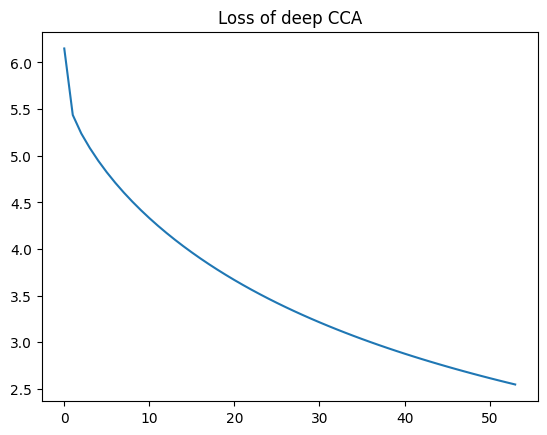

In [7]:
plt.plot(loss_list)
plt.title("Loss of deep CCA")

Text(0.5, 1.0, 'Accuracy of estimated permutation')

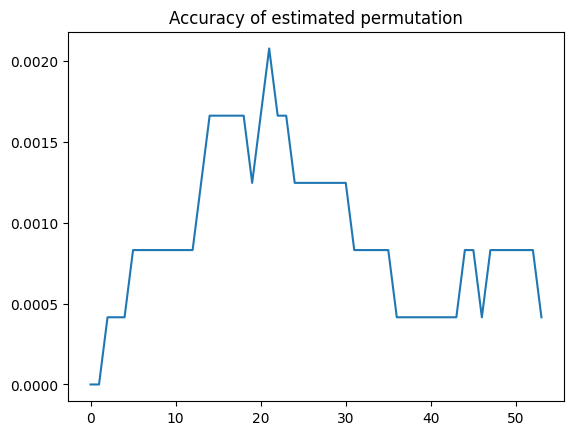

In [8]:
plt.plot(acc_list)
plt.title("Accuracy of estimated permutation")

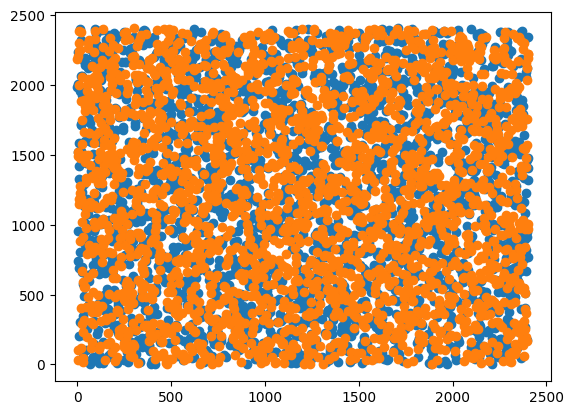

In [9]:
idx = [ii for ii in range(N)]
y_PI = []
y_true = []
for ii in range(N):
    esti_idx = np.where(P[ii]==1)[0]
    if esti_idx.size > 0:
        esti_idx = esti_idx[0]
    true_idx = np.where(true_PI[ii]==1)[0]
    y_PI.append(esti_idx)
    y_true.append(true_idx)
plt.scatter(idx, y_PI)
plt.scatter(idx, y_true)
plt.show()